#### Imports

In [27]:
import numpy as np
import os

from spiegelib.estimator import ParameterLoss
from matplotlib import pyplot as plt
import seaborn as sns
import spiegelib as spgl
import itertools
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

sns.set_theme()

#### All metrics are defined here

In [4]:
def calculateMPE(truePatches, predictedPatches):
    """
    Calculates the mean absolute parameter error
    Args:
        truePatches:
        predictedPatches:

    Returns: a list of mean errors for each parameter and std errors
    """
    errors = []
    for true, predicted in zip(truePatches, predictedPatches):
        patchErrors = []
        for trueParam, predictedParam in zip(true, predicted):
            error = abs(trueParam - predictedParam)
            patchErrors.append(error)
        errors.append(patchErrors)
    errors_mean = np.mean(np.array(errors), axis=0)
    errors_std = np.std(np.array(errors), axis=0)
    return errors_mean, errors_std

In [5]:
def calculateMAE(truePatches, predictedPatches):
    errors = []
    for true, predicted in zip(truePatches, predictedPatches):
        patchError = 0
        for trueParam, predictedParam in zip(true, predicted):
            error = abs(trueParam - predictedParam)
            patchError += error
        #Calculate avg parameter error of a sample
        patchError = patchError / len(true)
        errors.append(patchError)
    errors = np.array(errors)
    mean = np.mean(errors)
    std = np.std(errors)
    return errors, mean, std

In [6]:
def calculateMFCC(trueAudio, predictedAudio):
    evaluation = spgl.evaluation.MFCCEval(trueAudio, predictedAudio)
    evaluation.evaluate()
    mfccDistances = []
    for key, value in evaluation.get_scores().items():
        error = value['source_0']['mean_abs_error']
        mfccDistances.append(error)
    mfccDistances = np.array(mfccDistances)
    mean = np.mean(mfccDistances)
    std = np.std(mfccDistances)
    return mfccDistances, mean, std

### Load all data

In [7]:
datasetName = "evaluation"

automatableKeys = np.load("../data/presets/lfo/automatable_12.npy", allow_pickle=True)
weightsDict = np.load("../data/presets/lfo/weights_12.npy", allow_pickle=True).item()
weights = [weightsDict.get(key) for key in automatableKeys]

parameterModel = np.load("../data/presets/allParamsUpdatedNew.npy", allow_pickle=True)

#True audio and patches
true_audio = spgl.AudioBuffer.load_folder(f"../data/{datasetName}/audio")
true_patch = np.load(f"../data/{datasetName}/patch/patches.npy", allow_pickle=True)


#Load all configs:

#Run all configurations!
allBins = [4, 8, 12, 16, 32]
allDatasets = ["uniform", "normal", "preset"]
pred_audio = {}
pred_patch = {}

#Setup metrics
mfcc_scores = {}
mpe_scores = {}
mae_scores = {}

for dataset, bins in list(itertools.product(allDatasets, allBins)):
    pred_audio[(dataset, bins)] = [spgl.AudioBuffer.load_folder(f"../data/{datasetName}/predict_{dataset}_{bins}")]
    pred_patch[(dataset, bins)] = np.load(f"../data/{datasetName}/predict_{dataset}_{bins}/params.npy", allow_pickle=True)


C:\Users\hugod\Anaconda3\envs\spiegelib\lib\site-packages\librosa\util\decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


### Plot MPE

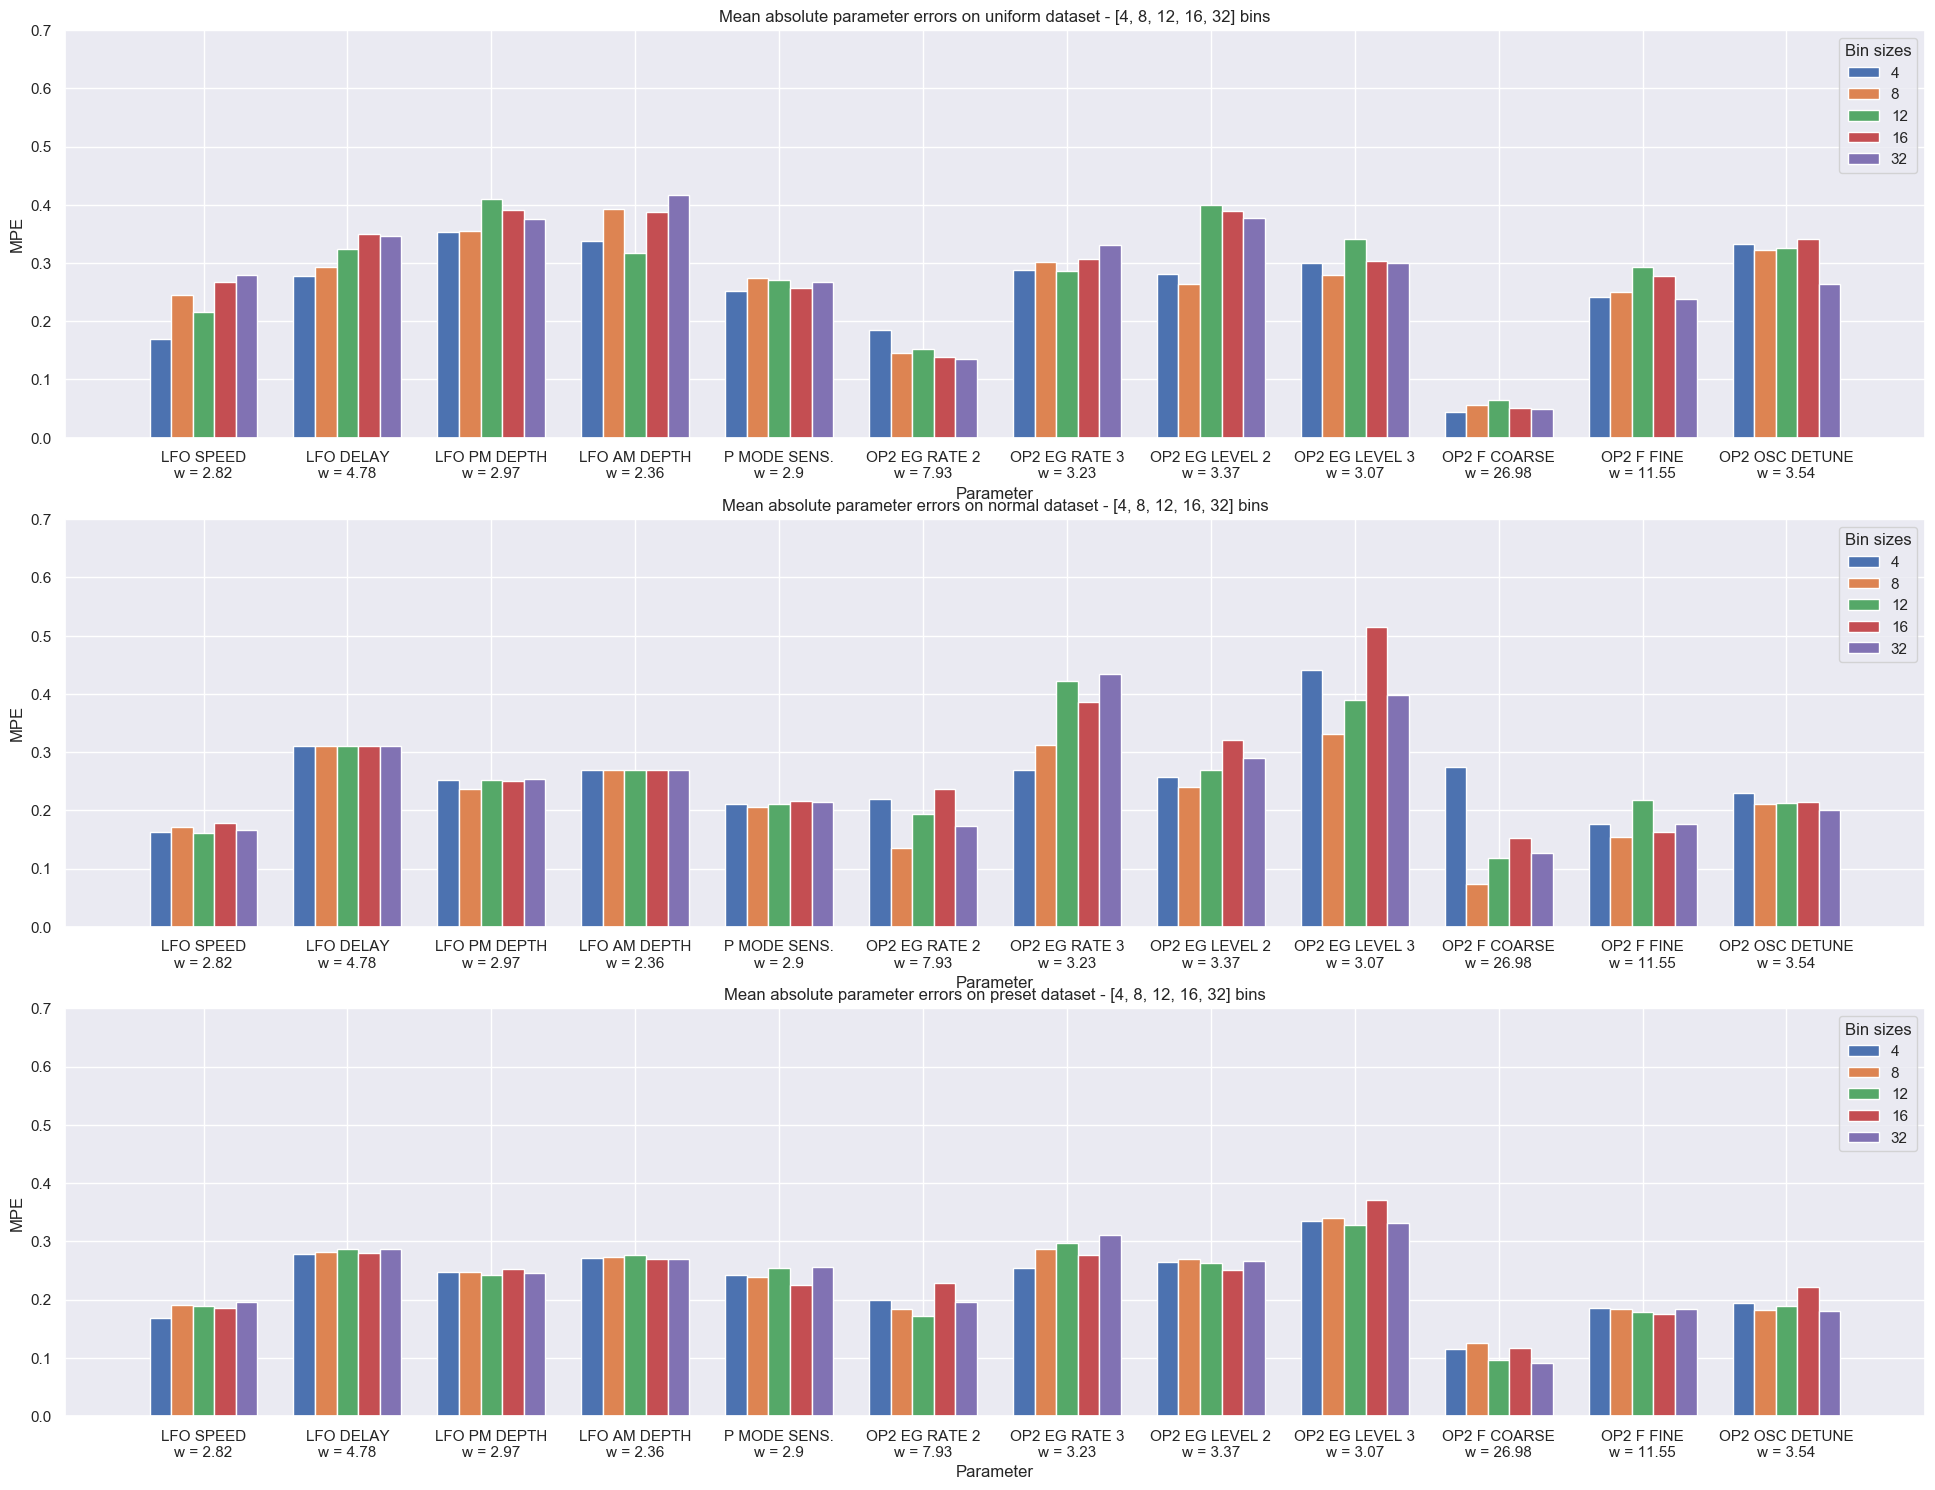

In [8]:
#Generate 3 plots for each dataset (now only 2)

fix, axes = plt.subplots(3, 1, figsize=(2 * len(automatableKeys), 18))


n = len(automatableKeys)
r = np.arange(n)

for ax, currDataset in zip(axes, allDatasets):
    width = 0.15
    position = - width * 2
    x_bar = [x['name'] + f"\nw = {str(round(y, 2))}" for x, y in zip(parameterModel[automatableKeys], weights)]
    for bin in allBins:
        #Calculate mpe and store in dict
        mpe, mpe_std = calculateMPE(true_patch, pred_patch[(currDataset, bin)])
        mpe_scores[(currDataset, bin)] = (mpe, mpe_std)

        #Plot the bar
        ax.bar(r + position, height=mpe, width= width)
        position += width

    ax.legend(allBins, title="Bin sizes")
    ax.set_xlabel("Parameter")
    ax.set_ylabel("MPE")
    ax.set_title(f"Mean absolute parameter errors on {currDataset} dataset - {str(allBins)} bins")
    ax.set_xticks(r)
    ax.set_xticklabels(x_bar)
    ax.set_ylim(0,0.7)

plt.savefig("../data/plots/MPE.png")

plt.show()

### Plot MFCC

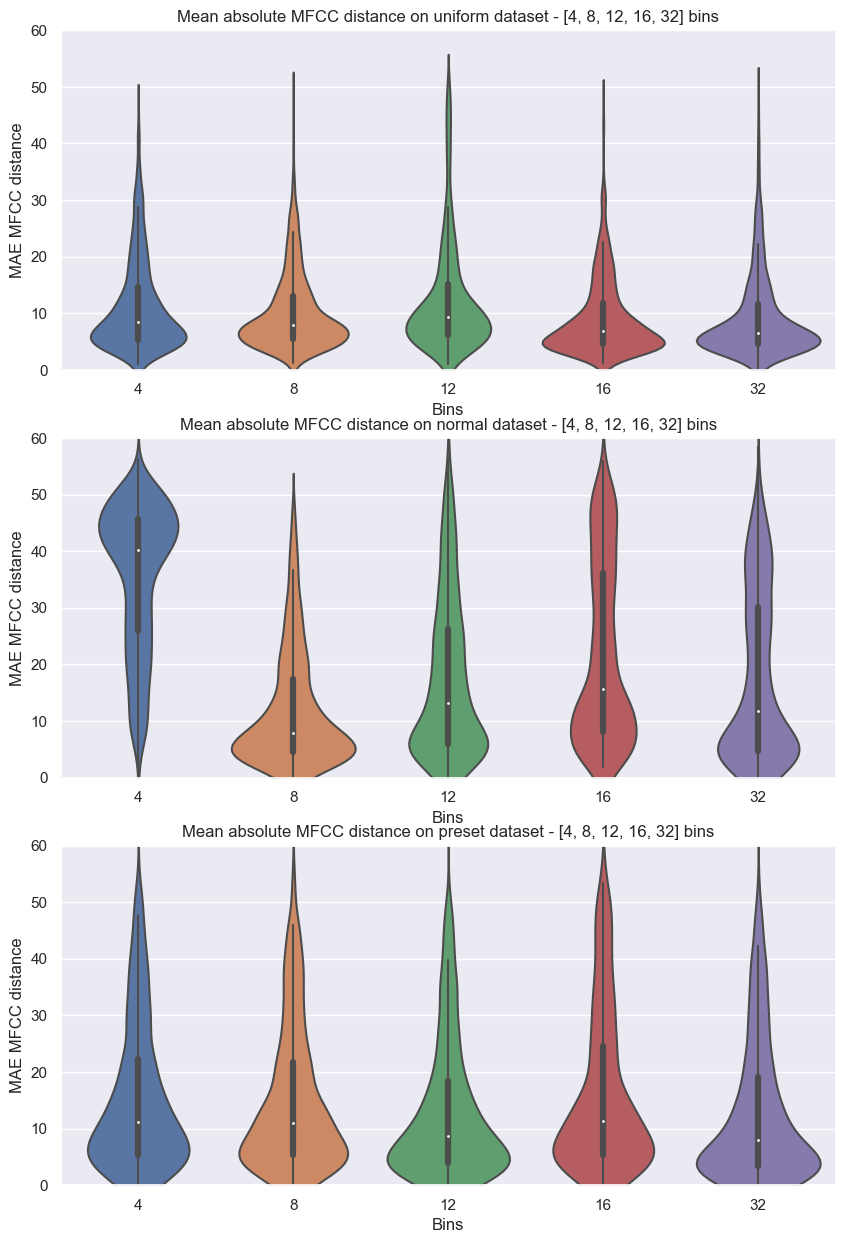

In [9]:
#Generate 3 plots for each dataset (now only 2)

fix, axes = plt.subplots(3, 1, figsize=(10, 15))

n = len(automatableKeys)
r = np.arange(n)

for ax, currDataset in zip(axes, allDatasets):
    dataDict = {}
    for bin in allBins:
        #Calculate mfcc and store in dict
        mfcc, mfcc_mean, mfcc_std = calculateMFCC(true_audio, pred_audio[(currDataset, bin)])
        mfcc_scores[(currDataset, bin)] = (mfcc, mfcc_mean, mfcc_std)
        dataDict[bin] = mfcc
    df = pd.DataFrame.from_dict(dataDict)
    sns.violinplot(df, ax=ax)
    ax.set_ylabel("MAE MFCC distance")
    ax.set_xlabel("Bins")
    ax.set_title(f"Mean absolute MFCC distance on {currDataset} dataset - {str(allBins)} bins")
    ax.set_ylim(0, 60)


plt.savefig("../data/plots/MFCC.png")

plt.show()

### Plot MAE over all samples

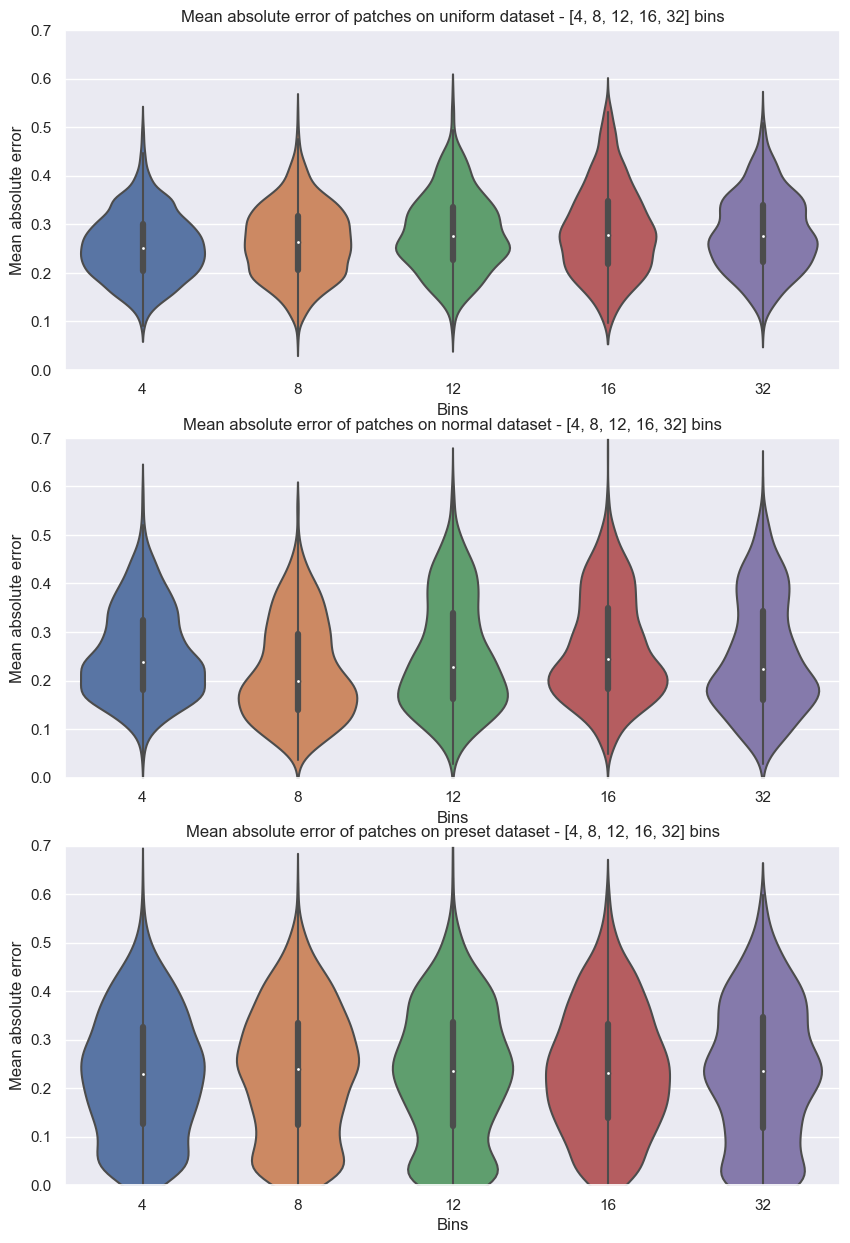

In [10]:
#Generate 3 plots for each dataset (now only 2)

fix, axes = plt.subplots(3, 1, figsize=(10, 15))

n = len(automatableKeys)
r = np.arange(n)

for ax, currDataset in zip(axes, allDatasets):
    dataDict = {}
    for bin in allBins:
        #Calculate mfcc and store in dict
        mae, mae_mean, mae_std = calculateMAE(true_patch, pred_patch[(currDataset, bin)])
        mae_scores[(currDataset, bin)] = (mae, mae_mean, mae_std)
        dataDict[bin] = mae
    df = pd.DataFrame.from_dict(dataDict)
    sns.violinplot(df, ax=ax)
    ax.set_ylabel("Mean absolute error")
    ax.set_xlabel("Bins")
    ax.set_title(f"Mean absolute error of patches on {currDataset} dataset - {str(allBins)} bins")
    ax.set_ylim(0, 0.7)


plt.savefig("../data/plots/MAE.png")

plt.show()

### Correlation analysis between MFCC and MAE

In [ ]:
#Generate 3 plots for each dataset (now only 2)

fix, axes = plt.subplots(1, 1, figsize=(10, 10))
totalMFCC = np.array([])
totalMAE = np.array([])
plotDict = {}

for currDataset in allDatasets:
    for bin in allBins:
        #Get scores for current configuration
        currMFCC = np.array(mfcc_scores[(currDataset, bin)][0])
        currMAE = np.array(mae_scores[(currDataset, bin)][0])
        totalMFCC = np.concatenate((totalMFCC, currMFCC))
        totalMAE = np.concatenate((totalMAE, currMAE))

#Create dict from data
plotDict['MFCC'] = totalMFCC
plotDict['MAE'] = totalMAE
df2 = pd.DataFrame.from_dict(plotDict)

#Normalize features between 0 and 1
scale_norm = MinMaxScaler()
scale_norm.fit_transform(df2)
df2 = pd.DataFrame(scale_norm.fit_transform(df2), columns = df2.columns)

sns.set_style("white")

sns.kdeplot(x=df2['MFCC'], y = df2['MAE'], cmap="Blues", fill=True, thresh=0)
plt.title(f"Correlation between MFCC Distance and MAE metrics (features normalized between 0 and 1)")


plt.savefig("../data/plots/Corr.png")

plt.show()

### Save scores

In [11]:
#Save scores: mfcc and MPE
np.save(f"../data/{datasetName}/scores/mfcc.npy", mfcc_scores)
np.save(f"../data/{datasetName}/scores/mpe.npy", mpe_scores)
np.save(f"../data/{datasetName}/scores/mae.npy", mae_scores)

### Show all scores

In [16]:
for mpe, mae, mfcc in zip(mpe_scores.items(), mae_scores.items(), mfcc_scores.items()):
    key = mpe[0]
    print(f"Curr key: {key}")
    print("MPE - MAE - MFCC")
    print(f" mean: {mpe[1][0]}")
    print(f" mean: {mae[1][1]} std: {mae[1][2]}")
    print(f" mean: {mfcc[1][1]} std: {mfcc[1][2]}")

Curr key: ('uniform', 4)
MPE - MAE - MFCC
 mean: [0.16910329 0.27683922 0.35365107 0.3381945  0.25245865 0.18439108
 0.28844166 0.28186307 0.29979285 0.04396844 0.24144604 0.33313904]
 mean: 0.25527407647705186 std: 0.06865171926996157
 mean: 11.38244915008545 std: 8.18887996673584
Curr key: ('uniform', 8)
MPE - MAE - MFCC
 mean: [0.2458187  0.29270946 0.35482882 0.39258764 0.27410514 0.14612011
 0.30132793 0.26327859 0.27913334 0.05633901 0.25025835 0.32227324]
 mean: 0.26489836231149355 std: 0.07447203025175786
 mean: 10.26783275604248 std: 6.742082595825195
Curr key: ('uniform', 12)
MPE - MAE - MFCC
 mean: [0.21551912 0.32335401 0.4106689  0.31770041 0.27070786 0.15152423
 0.28689355 0.39905037 0.3407134  0.06538775 0.29239974 0.3263233 ]
 mean: 0.2833535538773155 std: 0.08065011675247638
 mean: 12.573768615722656 std: 9.902070999145508
Curr key: ('uniform', 16)
MPE - MAE - MFCC
 mean: [0.26769237 0.34912556 0.39099887 0.38828691 0.25741058 0.13800861
 0.30648987 0.38852025 0.303492